# 1. Import Libraries/Dataset

## 1.a - Import required libraries

### Pip Install

In [58]:
!pip install -q tensorflow-gpu kaggle bs4 tensorflow_hub

### Import of needed packages

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from bs4 import BeautifulSoup
import unicodedata
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


## 1.b - Import the dataset

### Download dataset from Kaggle URL to colab

In [3]:
kaggle_userid = "balakavinpon"
kaggle_api_access_token = "496afaa8becf1cc5f72cf2d1551xxxxx" # last 5 char of API token was masked

!mkdir .kaggle
import json
token = {"username" : kaggle_userid, "key" : kaggle_api_access_token}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
  
!mkdir -p ~/.kaggle/
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
## Source as given in the problem statement - https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie- reviews/notebooks
!kaggle datasets download -p /content -d 'lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'
!ls -l

- path is now set to: {/content}
 66% 17.0M/25.7M [00:01<00:00, 9.45MB/s]
100% 25.7M/25.7M [00:01<00:00, 15.7MB/s]
total 26340
drwx------ 4 root root     4096 Oct 19 15:05 drive
-rw-r--r-- 1 root root 26962657 Oct 19 15:07 imdb-dataset-of-50k-movie-reviews.zip
drwxr-xr-x 1 root root     4096 Oct 14 16:31 sample_data


### Import Dataset to Pandas

In [4]:
import zipfile
zf = zipfile.ZipFile('imdb-dataset-of-50k-movie-reviews.zip') 
df = pd.read_csv(zf.open('IMDB Dataset.csv'))

## 1.c - Check the GPU availablity & Version of TF

In [5]:
#Verify if tensorflow 2.x is being used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Checking for GPU availability
print("Is GPU enabled in this machine? \n{}".format(tf.config.list_physical_devices('GPU')))

Is GPU enabled in this machine? 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Data Visualization

### Explore the Data

In [6]:
print('Shape ->',df.shape)
df.head()

Shape -> (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.describe()


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


## 2.a Sample Reviews to Explore

### Positive Reviews

In [8]:
with pd.option_context('display.max_colwidth', None):
  display(df[df['sentiment']=='positive'].head(2))


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


### Negative Reviews

In [9]:
with pd.option_context('display.max_colwidth', None):
  display(df[df['sentiment']=='negative'].head(2))

,review,sentiment
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",negative
7,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air.",negative


## 2.b - Graph Ploting 

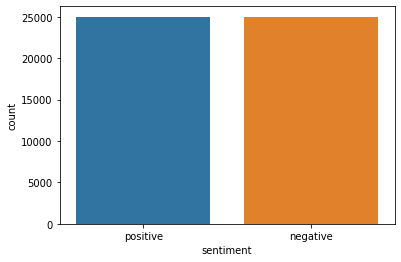

In [10]:
import seaborn as sns
ax = sns.countplot(x="sentiment", data=df)


### Test Train Split & its Shape 

In [11]:

X = df['review']
Y=df['sentiment']
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

X_train, X_test, Y_train,Y_test = train_test_split(X, encoded_Y, test_size=0.3,shuffle= True, random_state=100)
print('X-Train  Shape ->',X_train.shape)
print('X-Test  Shape ->',X_test.shape)
print('Y-Train  Shape ->',Y_train.shape)
print('Y-Test  Shape ->',Y_test.shape)



X-Train  Shape -> (35000,)
X-Test  Shape -> (15000,)
Y-Train  Shape -> (35000,)
Y-Test  Shape -> (15000,)


# 3. Data Clean Up and Pre-Procesing

Observation on review text 
- html tags are found , which needs to be removed
- Uppercase and lower case charectors are present. Changing entire text to lower case for consistancy
- Special charectors found - should be removed using regex
- non ascii charectors found - should be removed 
- words are seperated by more than one space - should be changed to single space char


### Data Cleaning Methods

In [12]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


### Overall Pre-Processing

In [13]:
def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document

### Vetorized pre-processing on Test and Train dataset

In [14]:
pre_process_corpus = np.vectorize(pre_process_document)

X_train = pre_process_corpus(X_train)
X_test = pre_process_corpus(X_test)


### Pre-tranined embedding layer

In [15]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",
                           input_shape=[], dtype=tf.string)

# 4. Model Building

In [47]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               249285376 
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 249,296,053
Trainable params: 10,677
Non-trainable params: 249,285,376
___________________________________

### Justification

 Started with 2 hidden layers with 64 units and 10 units respectively , for 30 epochs and found the traning and validation loss and accuracy was moving closely , without much deviation or overfitting (without regularization added). Since regularization and Dropout are needed to reduce overfitting, added one more hidden layer which change the hidden units to 64 , 32, 10 respectively 

Finaly tried with 3 hidden layer with 64 , 32, 10 hidden units, with all L2 regularization added to all 3 hidden layers. and added dropout with 20% on the first hidden layer. 

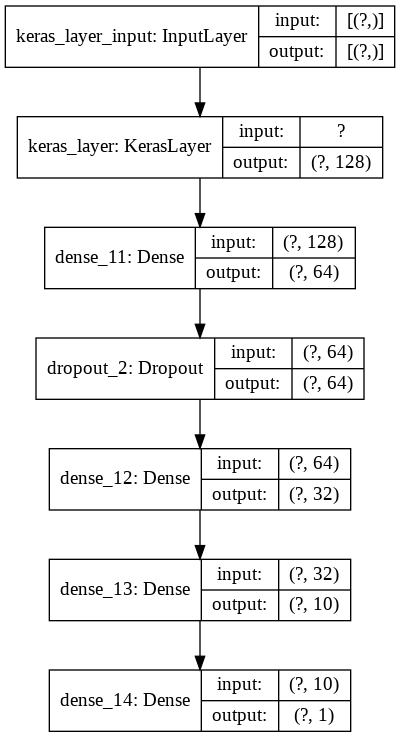

In [40]:
tf.keras.utils.plot_model(model,show_shapes=True)

# 5. Model Compilation

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])


# 6. Model Training 

In [42]:
import time
epochs_run = 30
batchsize = 64

# start time
start_time = time.perf_counter()

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.3, 
                    batch_size=batchsize, 
                    epochs=epochs_run,
                    verbose=1)
# Total time taken for training the given dataset
elapsed = time.perf_counter() - start_time

Epoch 1/30
383/383 [==============================] - 4s 11ms/step - loss: 0.9767 - accuracy: 0.5033 - val_loss: 0.8984 - val_accuracy: 0.4971
Epoch 2/30
383/383 [==============================] - 4s 10ms/step - loss: 0.8511 - accuracy: 0.5033 - val_loss: 0.8085 - val_accuracy: 0.4971
Epoch 3/30
383/383 [==============================] - 4s 10ms/step - loss: 0.7793 - accuracy: 0.5033 - val_loss: 0.7492 - val_accuracy: 0.4971
Epoch 4/30
383/383 [==============================] - 3s 9ms/step - loss: 0.7318 - accuracy: 0.5334 - val_loss: 0.7117 - val_accuracy: 0.6113
Epoch 5/30
383/383 [==============================] - 3s 9ms/step - loss: 0.7026 - accuracy: 0.6546 - val_loss: 0.6878 - val_accuracy: 0.6822
Epoch 6/30
383/383 [==============================] - 3s 9ms/step - loss: 0.6822 - accuracy: 0.7151 - val_loss: 0.6686 - val_accuracy: 0.7425
Epoch 7/30
383/383 [==============================] - 3s 9ms/step - loss: 0.6670 - accuracy: 0.7515 - val_loss: 0.6560 - val_accuracy: 0.7709
Epo

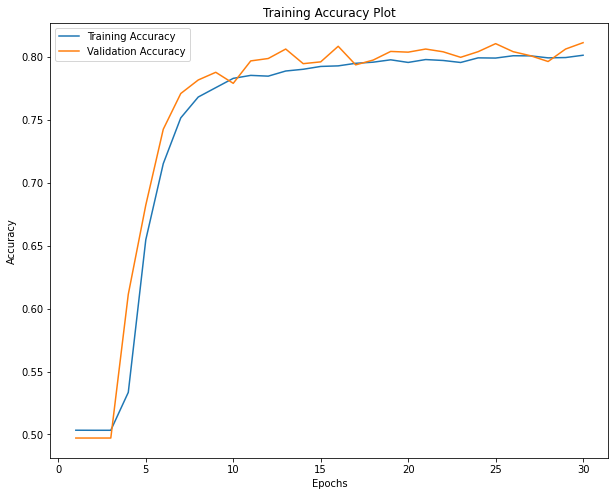

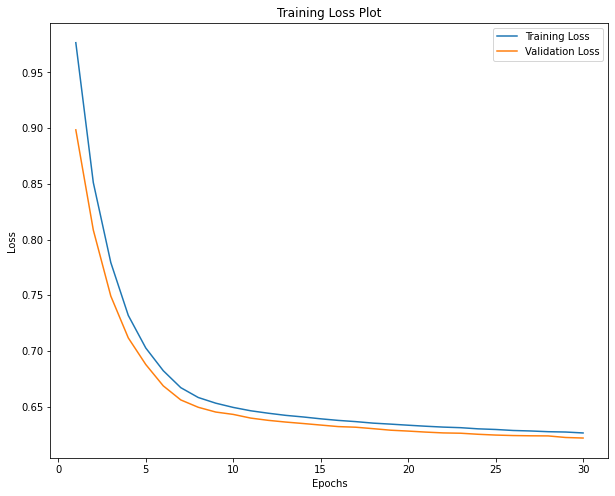

In [43]:
import matplotlib.pyplot as plt
def evaluation_plot(history):
  """
  Method plots the model training result
  :param history: history of the model epochs run
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  # Loss details
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(10,8))
  plt.plot(epochs, acc, label="Training Accuracy")
  plt.plot(epochs, val_acc, label="Validation Accuracy")
  plt.title("Training Accuracy Plot")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  # Loss and Validation loss plot
  plt.figure(figsize=(10,8))
  plt.plot(epochs, loss, label="Training Loss")
  plt.plot(epochs, val_loss, label="Validation Loss")
  plt.title("Training Loss Plot")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

evaluation_plot(history)

### Total time taken for training

In [44]:
print("=="*40)
print("Total time taken for training {:.2f} seconds".format(elapsed))
print("=="*40)


Total time taken for training 102.28 seconds


# 7.  Model Evaluation

In [31]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("=="*40)
print("Test Loss {:.2f}  &  Test Accuracy {:.2f} ".format(test_loss,test_acc))
print("=="*40)

469/469 [==============================] - 2s 4ms/step - loss: 0.6016 - accuracy: 0.8077
Test Loss 0.60  &  Test Accuracy 0.81 


In [45]:
Y_hat=model.predict(X_test).round()
print("Confusion Matrix: \n {}".format(classification_report(y_true=Y_test,y_pred=Y_hat)))

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      7449
           1       0.88      0.73      0.80      7551

    accuracy                           0.81     15000
   macro avg       0.82      0.81      0.81     15000
weighted avg       0.82      0.81      0.81     15000



# 8. Hyper Parameter tunning

## Changing Batch size on above defined model
  ### a) increasing the batch size  64 -> 512

In [48]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               249285376 
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 249,296,053
Trainable params: 10,677
Non-trainable params: 249,285,376
___________________________________

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [50]:
import time
epochs_run = 30
batchsize = 512

# start time
start_time = time.perf_counter()

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.3, 
                    batch_size=batchsize, 
                    epochs=epochs_run,
                    verbose=1)
# Total time taken for training the given dataset
elapsed = time.perf_counter() - start_time

Epoch 1/30
48/48 [==============================] - 2s 43ms/step - loss: 1.0560 - accuracy: 0.5023 - val_loss: 1.0395 - val_accuracy: 0.4971
Epoch 2/30
48/48 [==============================] - 2s 35ms/step - loss: 1.0261 - accuracy: 0.5033 - val_loss: 1.0077 - val_accuracy: 0.4971
Epoch 3/30
48/48 [==============================] - 2s 35ms/step - loss: 0.9966 - accuracy: 0.5033 - val_loss: 0.9820 - val_accuracy: 0.4971
Epoch 4/30
48/48 [==============================] - 2s 34ms/step - loss: 0.9730 - accuracy: 0.5033 - val_loss: 0.9610 - val_accuracy: 0.4971
Epoch 5/30
48/48 [==============================] - 2s 34ms/step - loss: 0.9529 - accuracy: 0.5033 - val_loss: 0.9423 - val_accuracy: 0.4971
Epoch 6/30
48/48 [==============================] - 2s 34ms/step - loss: 0.9350 - accuracy: 0.5033 - val_loss: 0.9250 - val_accuracy: 0.4971
Epoch 7/30
48/48 [==============================] - 2s 35ms/step - loss: 0.9182 - accuracy: 0.5033 - val_loss: 0.9088 - val_accuracy: 0.4971
Epoch 8/30
48

#### Accuracy and Loss graph plots 

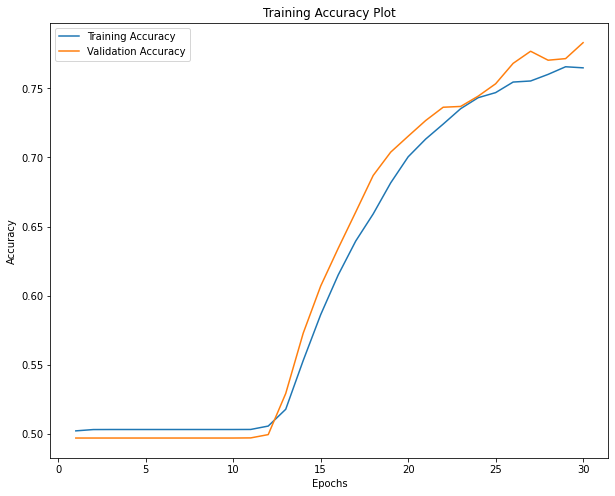

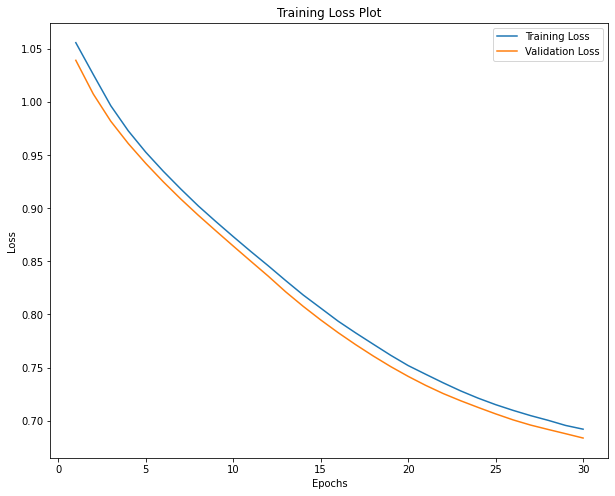

In [51]:
evaluation_plot(history)

#### Time taken and Test Loss & Accuracy

In [52]:
print("=="*40)
print("Total time taken for training {:.2f} seconds".format(elapsed))
print("=="*40)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print("=="*40)
print("Test Loss {:.2f}  &  Test Accuracy {:.2f} ".format(test_loss,test_acc))
print("=="*40)

Total time taken for training 52.69 seconds
469/469 [==============================] - 2s 4ms/step - loss: 0.6837 - accuracy: 0.7803
Test Loss 0.68  &  Test Accuracy 0.78 


### Observation

- Total run time came down from 100 sec to 52 sec
- Accuracy started increasing after 12 epochs 
- still lot of room for accuracy imporvement, number epochs has to be increased in this case. which can clearly seen from the graph

## Changing Batch size on above defined model
### b) decreasing the batch size 64 -> 5

In [53]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               249285376 
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 249,296,053
Trainable params: 10,677
Non-trainable params: 249,285,376
___________________________________

In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [55]:
import time
epochs_run = 30
batchsize = 5

# start time
start_time = time.perf_counter()

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.3, 
                    batch_size=batchsize, 
                    epochs=epochs_run,
                    verbose=1)
# Total time taken for training the given dataset
elapsed = time.perf_counter() - start_time

Epoch 1/30
4900/4900 [==============================] - 21s 4ms/step - loss: 0.7622 - accuracy: 0.6284 - val_loss: 0.6684 - val_accuracy: 0.7341
Epoch 2/30
4900/4900 [==============================] - 20s 4ms/step - loss: 0.6597 - accuracy: 0.7726 - val_loss: 0.6458 - val_accuracy: 0.7761
Epoch 3/30
4900/4900 [==============================] - 20s 4ms/step - loss: 0.6463 - accuracy: 0.7831 - val_loss: 0.6380 - val_accuracy: 0.7763
Epoch 4/30
4900/4900 [==============================] - 21s 4ms/step - loss: 0.6387 - accuracy: 0.7914 - val_loss: 0.6301 - val_accuracy: 0.8076
Epoch 5/30
4900/4900 [==============================] - 20s 4ms/step - loss: 0.6346 - accuracy: 0.7916 - val_loss: 0.6266 - val_accuracy: 0.7998
Epoch 6/30
4900/4900 [==============================] - 20s 4ms/step - loss: 0.6310 - accuracy: 0.7950 - val_loss: 0.6239 - val_accuracy: 0.8045
Epoch 7/30
4900/4900 [==============================] - 20s 4ms/step - loss: 0.6287 - accuracy: 0.7952 - val_loss: 0.6229 - val_ac

### Accuracy & Loss graph plot

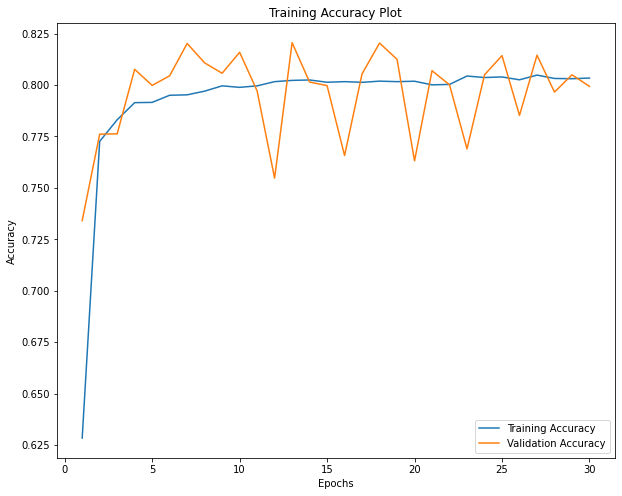

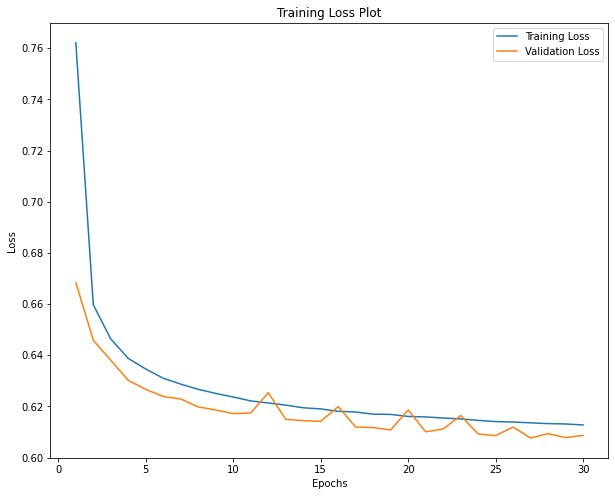

In [59]:
evaluation_plot(history)

### Time Taken, Test Loss & Accuracy

In [60]:
print("=="*40)
print("Total time taken for training {:.2f} seconds".format(elapsed))
print("=="*40)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print("=="*40)
print("Test Loss {:.2f}  &  Test Accuracy {:.2f} ".format(test_loss,test_acc))
print("=="*40)

Total time taken for training 608.23 seconds
469/469 [==============================] - 2s 4ms/step - loss: 0.6076 - accuracy: 0.8013
Test Loss 0.61  &  Test Accuracy 0.80 


### Observation
- run time increased from 100 to 600 sec, on reducing the batch size from 64 to 5 
- Shown lot of fluctuation in validation as the batch size is too low


## Changing optimizer (Adam to RMSProp)
  

In [70]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.003)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               249285376 
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 11        
Total params: 249,296,053
Trainable params: 10,677
Non-trainable params: 249,285,376
___________________________________

#### RMS Prop optimizer is being used

In [71]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, clipnorm=1.),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])


In [72]:
import time
epochs_run = 30
batchsize = 64

# start time
start_time = time.perf_counter()

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.3, 
                    batch_size=batchsize, 
                    epochs=epochs_run,
                    verbose=1)
# Total time taken for training the given dataset
elapsed = time.perf_counter() - start_time

Epoch 1/30
383/383 [==============================] - 4s 10ms/step - loss: 0.9660 - accuracy: 0.5032 - val_loss: 0.8880 - val_accuracy: 0.4971
Epoch 2/30
383/383 [==============================] - 4s 9ms/step - loss: 0.8352 - accuracy: 0.5033 - val_loss: 0.7894 - val_accuracy: 0.4971
Epoch 3/30
383/383 [==============================] - 4s 9ms/step - loss: 0.7603 - accuracy: 0.5035 - val_loss: 0.7328 - val_accuracy: 0.4986
Epoch 4/30
383/383 [==============================] - 4s 9ms/step - loss: 0.7176 - accuracy: 0.5533 - val_loss: 0.6999 - val_accuracy: 0.6213
Epoch 5/30
383/383 [==============================] - 4s 9ms/step - loss: 0.6933 - accuracy: 0.6521 - val_loss: 0.6804 - val_accuracy: 0.6822
Epoch 6/30
383/383 [==============================] - 4s 9ms/step - loss: 0.6776 - accuracy: 0.7131 - val_loss: 0.6655 - val_accuracy: 0.7396
Epoch 7/30
383/383 [==============================] - 4s 9ms/step - loss: 0.6657 - accuracy: 0.7488 - val_loss: 0.6553 - val_accuracy: 0.7750
Epoch

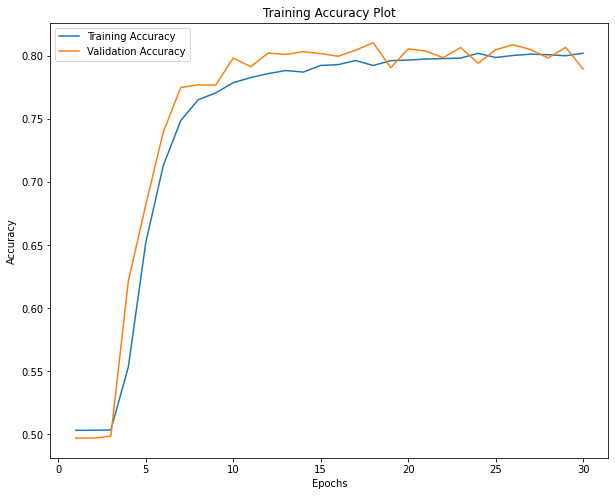

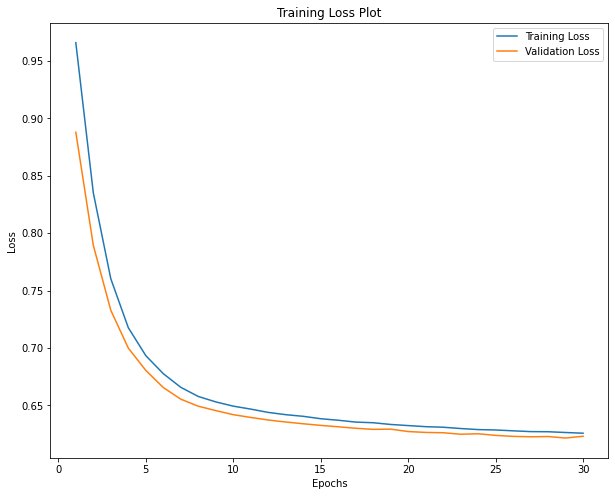

In [73]:
evaluation_plot(history)

In [74]:
print("=="*40)
print("Total time taken for training {:.2f} seconds".format(elapsed))
print("=="*40)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print("=="*40)
print("Test Loss {:.2f}  &  Test Accuracy {:.2f} ".format(test_loss,test_acc))
print("=="*40)

Total time taken for training 109.63 seconds
469/469 [==============================] - 2s 4ms/step - loss: 0.6221 - accuracy: 0.7910
Test Loss 0.62  &  Test Accuracy 0.79 


## Observation 
- Graph looks more simliar to Adam optimier curve

## Jut a try by incresing more hiddenlayers 
   as regularization and dropouts are in place to avoid overfitting

In [80]:

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()


model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, clipnorm=1.),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

import time
epochs_run = 30
batchsize = 64

# start time
start_time = time.perf_counter()

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.3, 
                    batch_size=batchsize, 
                    epochs=epochs_run,
                    verbose=1)
# Total time taken for training the given dataset
elapsed = time.perf_counter() - start_time

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               249285376 
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 17        
Total params: 249,311,201
Trainable params: 25,825
Non-trainable params: 249,285,376
__________________________________

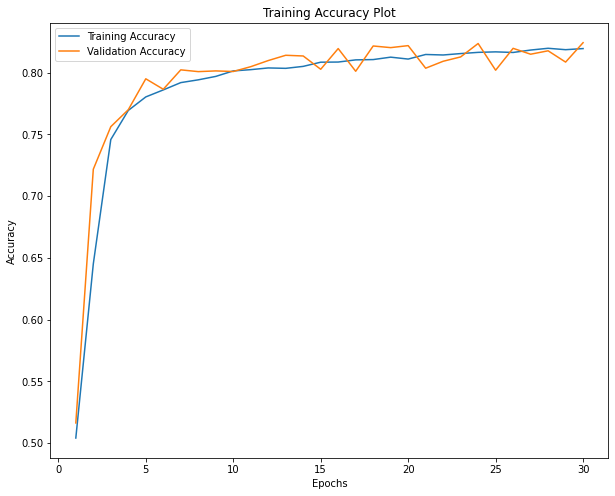

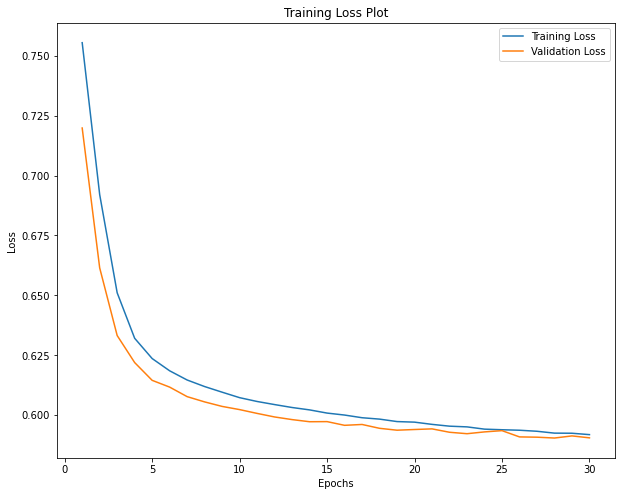

In [81]:
evaluation_plot(history)

In [82]:
print("=="*40)
print("Total time taken for training {:.2f} seconds".format(elapsed))
print("=="*40)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print("=="*40)
print("Test Loss {:.2f}  &  Test Accuracy {:.2f} ".format(test_loss,test_acc))
print("=="*40)

Total time taken for training 107.88 seconds
469/469 [==============================] - 2s 4ms/step - loss: 0.5902 - accuracy: 0.8263
Test Loss 0.59  &  Test Accuracy 0.83 
